In [8]:
# SECȚIUNEA 0 – Importuri de bază

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_theme()


In [11]:
from google.colab import files
uploaded = files.upload()


Saving reduced_cleaned_wine_data.xlsx to reduced_cleaned_wine_data.xlsx


In [12]:
# SECȚIUNEA 1 – Încărcare date
df = pd.read_excel("reduced_cleaned_wine_data.xlsx")

df.head()


,country,description,designation,points,price,province,region_1,region_2,variety,winery,title,vintage,alcohol,category
0,Spain,"Consistent with past vintages, this crianza ge...",Crianza,86.0,25.0,Northern Spain,Ribera del Duero,Central Coast,Tempranillo,Alidis,Alidis 2004 Crianza (Ribera del Duero),2004.0,14.0,Red
1,US,The Indelicato family's vineyard is basically ...,Three Crowns Single Vineyard,90.0,30.0,California,San Bernabe,Central Coast,Red Blend,Diora,Diora 2012 Three Crowns Single Vineyard Red (S...,2011.0,13.5,Red
2,Germany,Long extended veins of bramble and dried herb ...,Rotwein Trocken,90.0,34.0,Rheinhessen,Central Coast,Central Coast,SpГ¤tburgunder,Wittmann,Wittmann 2012 Rotwein Trocken SpГ¤tburgunder (...,2012.0,13.0,Red
3,Italy,This is a fresh and luminous blend of Sauvigno...,Vino Bianco,88.0,17.0,Piedmont,Monferrato,Central Coast,White Blend,Quattro Leoni,Quattro Leoni 2008 Vino Bianco White (Monferrato),2008.0,12.0,White
4,Italy,"Aromas of red berry, blue flower, menthol, exo...",Sassicaia,95.0,235.0,Tuscany,Bolgheri Sassicaia,Central Coast,Red Blend,Tenuta San Guido,Tenuta San Guido 2014 Sassicaia (Bolgheri Sas...,2014.0,13.0,Red


In [13]:
# Inspectăm structura DataFrame-ului

df.shape        # (număr_rânduri, număr_coloane)


(57198, 14)

In [14]:
df.info()       # tipuri de date, coloane, valori lipsă aproximativ


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57198 entries, 0 to 57197
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      57198 non-null  object 
 1   description  57198 non-null  object 
 2   designation  57198 non-null  object 
 3   points       57198 non-null  float64
 4   price        57198 non-null  float64
 5   province     57198 non-null  object 
 6   region_1     57198 non-null  object 
 7   region_2     57198 non-null  object 
 8   variety      57198 non-null  object 
 9   winery       57198 non-null  object 
 10  title        57198 non-null  object 
 11  vintage      57198 non-null  float64
 12  alcohol      57198 non-null  float64
 13  category     57198 non-null  object 
dtypes: float64(4), object(10)
memory usage: 6.1+ MB


In [15]:
df.isna().sum() # numărul valorilor lipsă pe fiecare coloană


,0
country,0
description,0
designation,0
points,0
price,0
province,0
region_1,0
region_2,0
variety,0
winery,0


In [16]:
# SECȚIUNEA 2.1 – Identificăm coloanele numerice și categorice

num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

print("Coloane numerice:", num_cols)
print("Coloane categorice:", cat_cols)


Coloane numerice: ['points', 'price', 'vintage', 'alcohol']
Coloane categorice: ['country', 'description', 'designation', 'province', 'region_1', 'region_2', 'variety', 'winery', 'title', 'category']


In [17]:
# SECȚIUNEA 2.2 – Conversie explicită pentru coloanele cheie (dacă este nevoie)

# Ne asigurăm că price, points, alcohol sunt numerice
for col in ["price", "points", "alcohol"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Ne asigurăm că country, province, variety, winery, category sunt categorice
for col in ["country", "province", "region_1", "region_2", "variety", "winery", "category"]:
    if col in df.columns:
        df[col] = df[col].astype("category")


In [18]:
# SECȚIUNEA 2.3 – Tratarea valorilor lipsă
# Numeric: completăm cu mediana
# Categoric: completăm cu "Unknown"

from pandas.api.types import is_numeric_dtype, is_categorical_dtype

# Completăm numeric cu mediană
for col in num_cols:
    if col in df.columns and is_numeric_dtype(df[col]):
        df[col] = df[col].fillna(df[col].median())

# Completăm categoric cu "Unknown"
for col in cat_cols:
    if col in df.columns:
        # dacă este tip Categorical, îl convertim la string ca să putem pune valori noi
        if is_categorical_dtype(df[col]):
            df[col] = df[col].astype("object")
        df[col] = df[col].fillna("Unknown")

# Verificare finală valori lipsă
df.isna().sum()


/tmp/ipython-input-1360017544.py:16: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(df[col]):
/tmp/ipython-input-1360017544.py:16: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(df[col]):
/tmp/ipython-input-1360017544.py:16: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(df[col]):
/tmp/ipython-input-1360017544.py:16: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(df[col]):
/tmp/ipython-input-1360017544.py:16: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a fut

,0
country,0
description,0
designation,0
points,0
price,0
province,0
region_1,0
region_2,0
variety,0
winery,0


In [19]:
# SECȚIUNEA 2.4 – Eliminarea rândurilor duplicate

dup_before = df.duplicated().sum()
print("Număr de duplicate înainte:", dup_before)

df = df.drop_duplicates()

dup_after = df.duplicated().sum()
print("După eliminare duplicate:", dup_after)
print("Număr total de rânduri după curățare:", len(df))


Număr de duplicate înainte: 0
După eliminare duplicate: 0
Număr total de rânduri după curățare: 57198


In [20]:
# SECȚIUNEA 2.5 – Crearea variabilei price_per_point

df["price_per_point"] = df["price"] / df["points"]

df[["price", "points", "price_per_point"]].head()


,price,points,price_per_point
0,25.0,86.0,0.290698
1,30.0,90.0,0.333333
2,34.0,90.0,0.377778
3,17.0,88.0,0.193182
4,235.0,95.0,2.473684


In [21]:
# SECȚIUNEA 3.1 – Statistici descriptive numerice

numeric_cols = ["price", "points", "alcohol", "price_per_point"]
numeric_cols = [c for c in numeric_cols if c in df.columns]

df[numeric_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
price,57198.0,32.304930,33.195029,4.000000,20.000000,25.000000,35.000000,2500.000000
points,57198.0,88.515612,3.146780,80.000000,86.000000,88.000000,91.000000,100.000000
alcohol,57198.0,13.637061,13.696953,0.000000,13.500000,13.500000,14.000000,3000.000000
price_per_point,57198.0,0.360868,0.350543,0.047619,0.222222,0.282353,0.402299,26.041667


In [22]:
# SECȚIUNEA 3.2 – Distribuții pe categorice

if "country" in df.columns:
    print("Top 10 țări după număr de vinuri:")
    print(df["country"].value_counts().head(10))

if "category" in df.columns:
    print("\nDistribuția categoriilor de vin:")
    print(df["category"].value_counts())

if "variety" in df.columns:
    print("\nTop 10 soiuri (variety):")
    print(df["variety"].value_counts().head(10))


Top 10 țări după număr de vinuri:
country
US              26115
France           8736
Italy            7926
Spain            2876
Portugal         1844
Australia        1582
Chile            1493
Argentina        1392
Austria           919
South Africa      868
Name: count, dtype: int64

Distribuția categoriilor de vin:
category
Red            39195
White          14077
Sparkling       1358
Rose            1352
Dessert          551
Rosé             392
Port/Sherry      242
Fortified         17
Orange            14
Name: count, dtype: int64

Top 10 soiuri (variety):
variety
Pinot Noir                  9883
Chardonnay                  5038
Cabernet Sauvignon          4253
Red Blend                   2924
Bordeaux-style Red Blend    2238
Syrah                       2069
Sauvignon Blanc             2002
Merlot                      1694
Riesling                    1589
Zinfandel                   1452
Name: count, dtype: int64


In [23]:
# SECȚIUNEA 4.1 – Agregări pe țări

group_country = (
    df.groupby("country")
      .agg(
          mean_price=("price", "mean"),
          mean_points=("points", "mean"),
          count_wines=("country", "count"),
          mean_price_per_point=("price_per_point", "mean")
      )
      .sort_values("count_wines", ascending=False)
)

group_country.head(10)


,mean_price,mean_points,count_wines,mean_price_per_point
country,,,,
US,34.677097,88.500172,26115,0.387979
France,34.736493,89.110691,8736,0.384101
Italy,33.326836,88.725334,7926,0.371860
Spain,26.025382,87.666551,2876,0.293627
Portugal,26.822939,88.413232,1844,0.298820
Australia,28.213021,88.356511,1582,0.315125
Chile,20.622237,86.438714,1493,0.236004
Argentina,23.491379,86.918103,1392,0.266611
Austria,30.547323,90.192601,919,0.336061


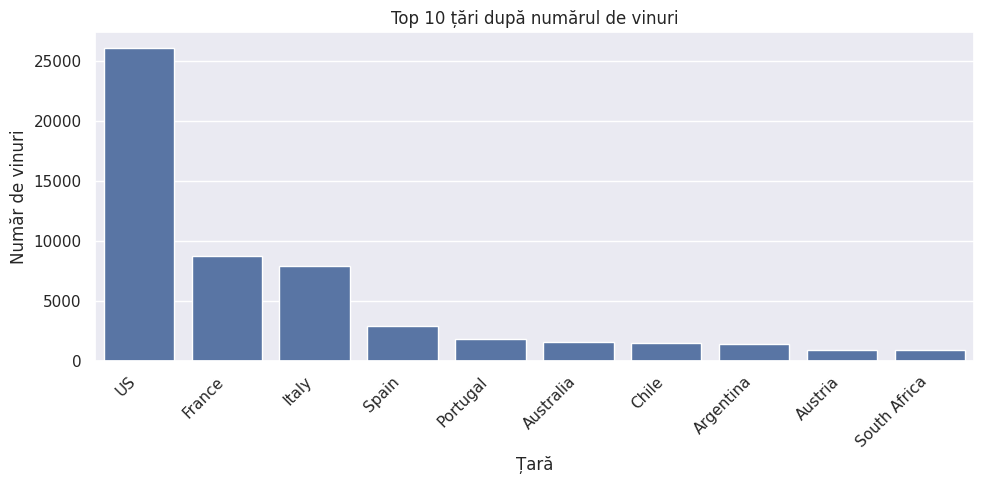

In [24]:
# SECȚIUNEA 4.2 – Bar chart pentru Top 10 țări după numărul de vinuri

top10_countries = group_country.head(10).reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=top10_countries, x="country", y="count_wines")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 țări după numărul de vinuri")
plt.xlabel("Țară")
plt.ylabel("Număr de vinuri")
plt.tight_layout()
plt.show()


In [25]:
# SECȚIUNEA 4.3 – Agregări pe soiuri (variety)

if "variety" in df.columns:
    variety_stats = (
        df.groupby("variety")
          .agg(
              mean_price=("price", "mean"),
              mean_points=("points", "mean"),
              count_wines=("variety", "count"),
              mean_price_per_point=("price_per_point", "mean")
          )
          .sort_values("count_wines", ascending=False)
    )

    variety_stats.head(10)


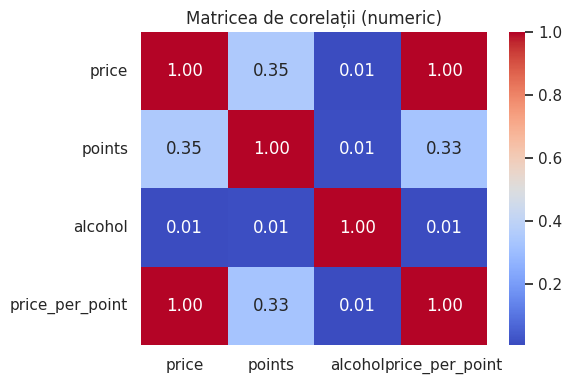

In [26]:
# SECȚIUNEA 5.1 – Matrice de corelație și heatmap

corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matricea de corelații (numeric)")
plt.tight_layout()
plt.show()


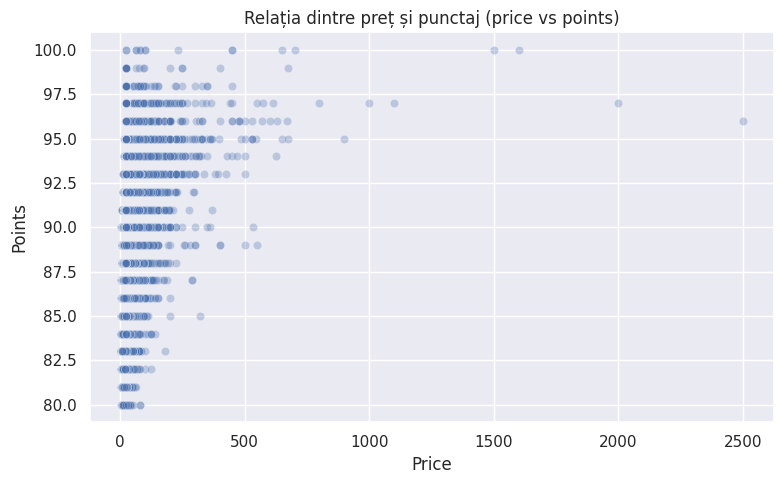

In [27]:
# SECȚIUNEA 5.2 – Scatter plot price vs points

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="price", y="points", alpha=0.3)
plt.title("Relația dintre preț și punctaj (price vs points)")
plt.xlabel("Price")
plt.ylabel("Points")
plt.tight_layout()
plt.show()


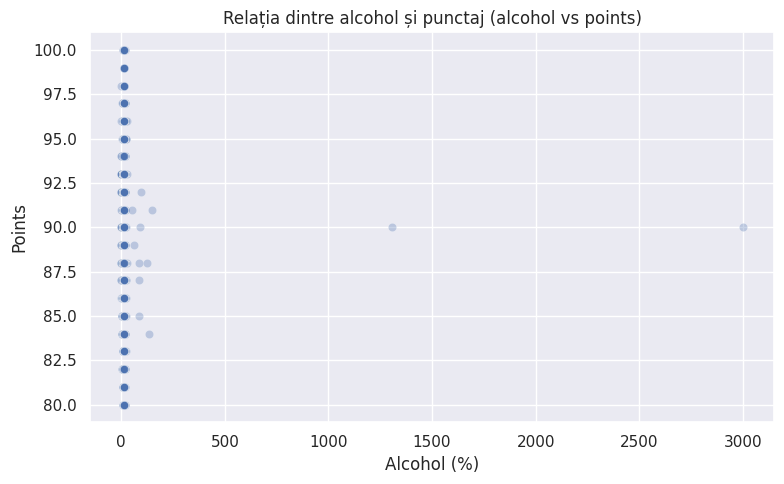

In [28]:
# SECȚIUNEA 5.3 – Scatter plot alcohol vs points

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="alcohol", y="points", alpha=0.3)
plt.title("Relația dintre alcohol și punctaj (alcohol vs points)")
plt.xlabel("Alcohol (%)")
plt.ylabel("Points")
plt.tight_layout()
plt.show()


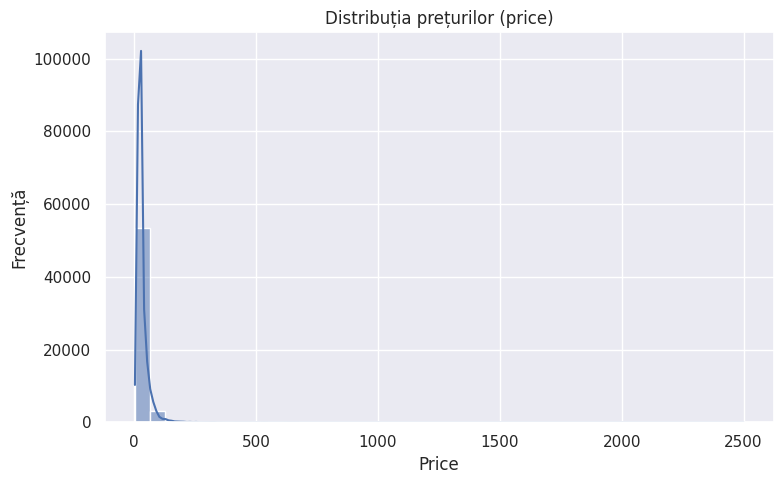

In [29]:
# SECȚIUNEA 6.1 – Histogramă pentru price

plt.figure(figsize=(8,5))
sns.histplot(df["price"], bins=40, kde=True)
plt.title("Distribuția prețurilor (price)")
plt.xlabel("Price")
plt.ylabel("Frecvență")
plt.tight_layout()
plt.show()


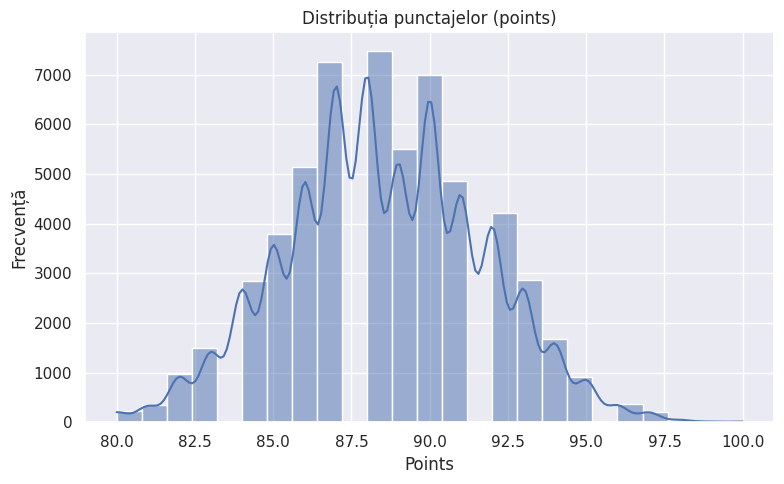

In [30]:
# Histogramă pentru points

plt.figure(figsize=(8,5))
sns.histplot(df["points"], bins=25, kde=True)
plt.title("Distribuția punctajelor (points)")
plt.xlabel("Points")
plt.ylabel("Frecvență")
plt.tight_layout()
plt.show()


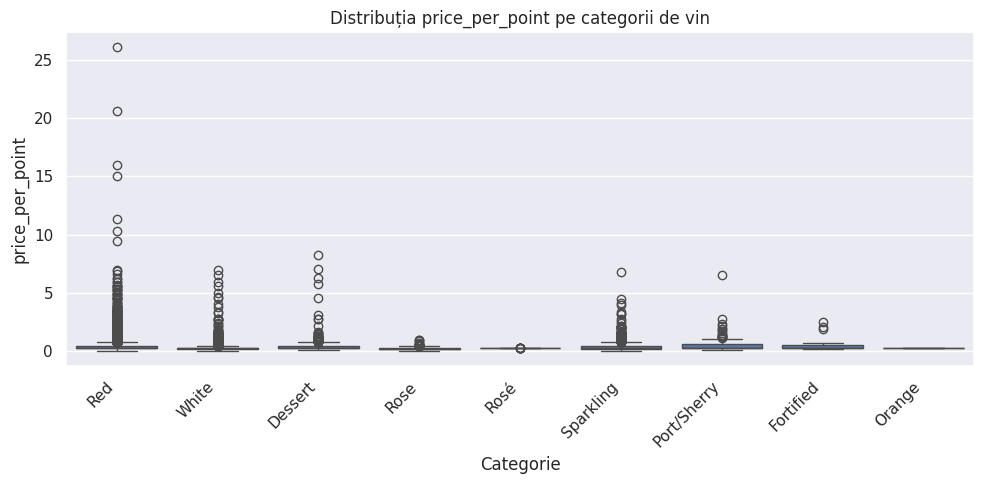

In [31]:
# SECȚIUNEA 6.2 – Boxplot price_per_point pe categorii de vin

if "category" in df.columns:
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df, x="category", y="price_per_point")
    plt.xticks(rotation=45, ha="right")
    plt.title("Distribuția price_per_point pe categorii de vin")
    plt.xlabel("Categorie")
    plt.ylabel("price_per_point")
    plt.tight_layout()
    plt.show()


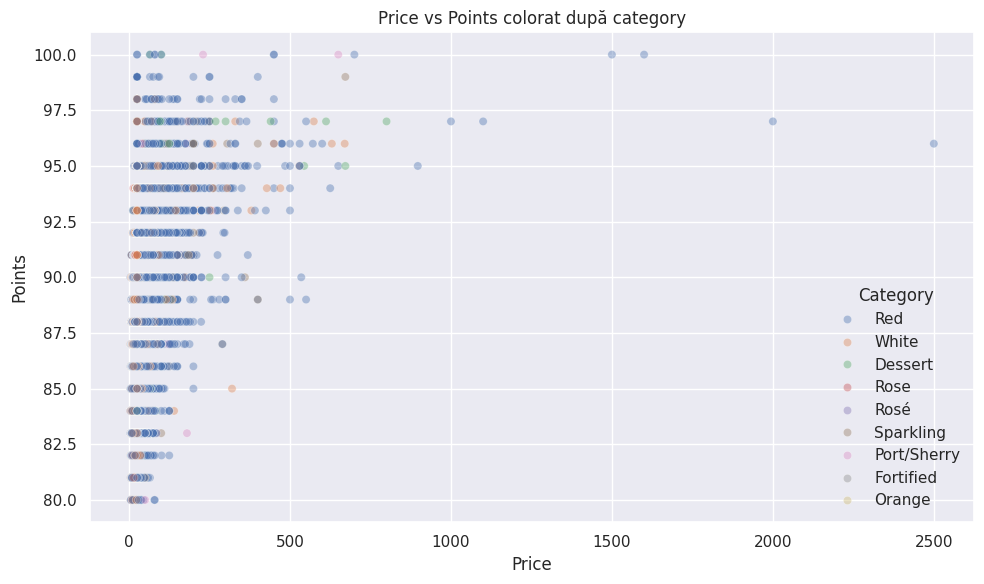

In [32]:
# SECȚIUNEA 6.3 – Scatter plot price vs points colorat după category

if "category" in df.columns:
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df, x="price", y="points", hue="category", alpha=0.4)
    plt.title("Price vs Points colorat după category")
    plt.xlabel("Price")
    plt.ylabel("Points")
    plt.legend(title="Category")
    plt.tight_layout()
    plt.show()


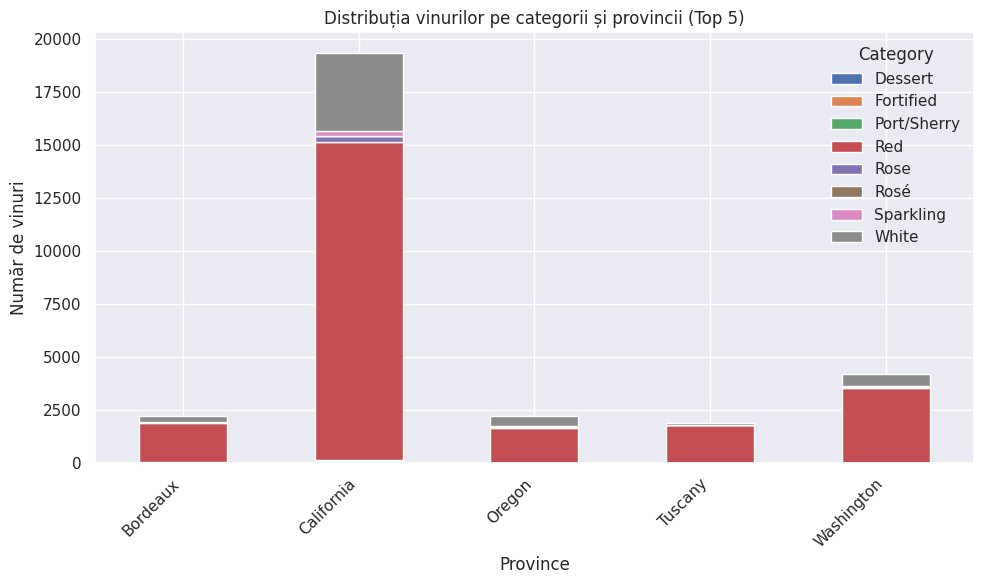

In [33]:
# SECȚIUNEA 6.4 – Stacked bar chart: category vs province (top 5 provincii)

if "province" in df.columns and "category" in df.columns:
    top_provinces = df["province"].value_counts().head(5).index
    df_sub = df[df["province"].isin(top_provinces)]

    crosstab_cat_prov = pd.crosstab(df_sub["province"], df_sub["category"])

    crosstab_cat_prov.plot(kind="bar", stacked=True, figsize=(10,6))
    plt.title("Distribuția vinurilor pe categorii și provincii (Top 5)")
    plt.xlabel("Province")
    plt.ylabel("Număr de vinuri")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Category")
    plt.tight_layout()
    plt.show()


In [34]:
# SECȚIUNEA 7.1 – Lungimea descrierilor (desc_length)

df["desc_length"] = df["description"].astype(str).apply(lambda x: len(x.split()))

df["desc_length"].describe()


,desc_length
count,57198.000000
mean,38.268279
std,13.242999
min,4.000000
25%,29.000000
50%,38.000000
75%,46.000000
max,152.000000


In [35]:
# SECȚIUNEA 7.2 – Curățare simplă text și cuvinte frecvente

import re

# concatenăm toate descrierile într-un singur text
text = " ".join(df["description"].astype(str))

# păstrăm doar litere și spații, transformăm în lowercase
text = re.sub(r"[^a-zA-Z ]", " ", text).lower()

words = text.split()

# stopwords simple (fără NLTK, pentru a evita problemele)
basic_stop = {
    "the", "and", "for", "with", "this", "that", "its", "are", "but", "from",
    "into", "has", "have", "will", "not", "was", "one", "also",
    "wine", "wines", "aroma", "aromas", "flavor", "flavors", "flavours",
    "palate", "finish", "note", "notes"
}

words_clean = [w for w in words if w not in basic_stop and len(w) > 2]

print("Număr de cuvinte după curățare:", len(words_clean))

# cele mai frecvente 20 de cuvinte
word_counts = Counter(words_clean).most_common(20)
word_counts


Număr de cuvinte după curățare: 1324351


[('fruit', 22208),
 ('tannins', 13779),
 ('acidity', 13416),
 ('cherry', 12684),
 ('black', 12003),
 ('ripe', 11067),
 ('drink', 10081),
 ('nose', 9492),
 ('red', 9072),
 ('oak', 8536),
 ('spice', 7895),
 ('rich', 7751),
 ('dry', 7471),
 ('fresh', 7026),
 ('now', 6748),
 ('sweet', 6375),
 ('full', 6286),
 ('berry', 5944),
 ('plum', 5785),
 ('well', 5781)]

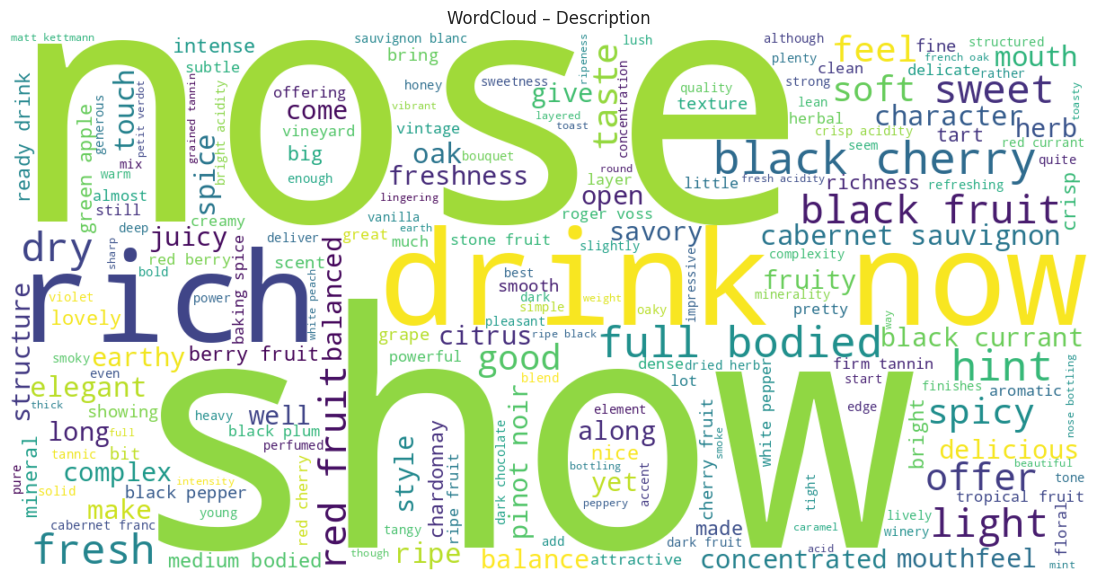

In [36]:
# SECȚIUNEA 7.3 – WordCloud pentru descrieri

wc = WordCloud(width=1200, height=600, background_color="white")
wc = wc.generate(" ".join(words_clean))

plt.figure(figsize=(14,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud – Description")
plt.show()


In [37]:
# SECȚIUNEA 8.1 – Document-Term Matrix (DTM) cu CountVectorizer

# folosim descrierea originală, fără preprocesare agresivă
vectorizer = CountVectorizer(
    max_features=300,      # cele mai frecvente 300 de cuvinte
    stop_words="english"   # elimină stopwords englezești de bază
)

X = vectorizer.fit_transform(df["description"].astype(str))

dtm = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# atașăm coloanele numerice pentru corelație
dtm["price"] = df["price"].values
dtm["points"] = df["points"].values


In [38]:
# SECȚIUNEA 8.2 – Cuvinte corelate cu prețul (price)

corr_price = dtm.corr(numeric_only=True)["price"].sort_values(ascending=False)

# primele 20 cuvinte cu corelație pozitivă
corr_price.head(20)


,price
price,1.000000
points,0.348950
years,0.146721
black,0.102056
cabernet,0.097528
tannins,0.097107
age,0.089720
vineyard,0.088765
powerful,0.084191
power,0.083862


In [39]:
# ultimele 20 (corelație negativă puternică)
corr_price.tail(20)


,price
finish,-0.037529
lemon,-0.038410
medium,-0.038692
nose,-0.040053
blanc,-0.041724
lime,-0.042079
refreshing,-0.042340
green,-0.046884
fruity,-0.047446
fresh,-0.047755


In [40]:
# SECȚIUNEA 8.3 – Cuvinte corelate cu punctajul (points)

corr_points = dtm.corr(numeric_only=True)["points"].sort_values(ascending=False)

corr_points.head(20)   # corelație pozitivă


,points
points,1.000000
price,0.348950
black,0.173384
rich,0.166207
years,0.158987
complex,0.154271
vineyard,0.148657
long,0.148464
concentrated,0.140091
tannins,0.129621


In [41]:
corr_points.tail(20)   # corelație negativă


,points
bitter,-0.061913
sour,-0.063659
like,-0.063929
fruity,-0.066593
finishes,-0.066627
pleasant,-0.067638
light,-0.069751
slightly,-0.071578
green,-0.077451
sharp,-0.078648


In [42]:
# SECȚIUNEA 9 – Salvarea datasetului curățat pentru aplicația Streamlit

df.to_csv("wine_cleaned.csv", index=False)
